# Titanic Data Analysis

## The Problem
**On April 15, 1912**, the Titanic sank after colliding with an iceberg, killing **1502 out of 2224** passengers and crew. Predicting which passengers lived and which died is a classic problem in data science. The classic dataset on Titanic passengers includes **12 variables**:

1. PassengerId
2. Survival
3. Pclass
4. Name
5. Sex
6. Age
7. SibSp
8. Parch
9. Ticket
10. Fare
11. Cabin
12. Embarked

The task is to predict the `Survived` variable using the other ten variables.

We begin by loading the data for the 'titanic' competition.

In [1]:
import pandas as pd

# Try to import from kaggle/input/titanic/, otherwise create it and download the data
train = pd.read_csv(filepath_or_buffer='/kaggle/input/titanic/train.csv')
test = pd.read_csv(filepath_or_buffer='/kaggle/input/titanic/test.csv')

Note that the data is pre-split into train and test sets by Kaggle.

## Variables

Our next task is to grok the training dataset to see what variables are available to us. Useful functions for this include:

- `df.shape()`, which gives us the number of rows and columns in the DataFrame
- `df.columns()`, which gives us the names of the columns
- `df.head()`, which gives us the first five rows of the DataFrame, or `df.tail()`, which gives us the last five rows of the DataFrame
- `df.sample(n)` or `df.sample(frac)`, which gives us a random sample of `n` rows or `frac` fraction of the rows, respectively
- `df.info()`, which gives us the number of non-null entries in each column, as well as the data type of each column
- `df.describe()`, which gives us summary statistics for each column
- `df.value_counts()`, which gives us the number of occurrences of each value in a column
- `df.unique()`, which gives us the unique values in a column

For example,

In [2]:
# Get column names and non-null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Count unique values for each int64 or object column
for column in train.select_dtypes(include=['int64', 'object']).columns:
    print(column, train[column].nunique())

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
SibSp 7
Parch 7
Ticket 681
Cabin 147
Embarked 3


In [4]:
# Count occurrences of each unique value in columns with only a few unique values
for column in train.select_dtypes(include=['int64', 'object']).columns:
    if train[column].nunique() < 10:
        print(train[column].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [5]:
# Use describe to statistically summarize float64 columns
train.select_dtypes(include=['float64']).describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200



Based on our examination of the data (and Kaggle-provided [metadata](https://www.kaggle.com/c/titanic/data) about what the various variables represent), we can make the following observations:

1. **Age**: Most ages are round numbers, but some are fractional because they are either estimated or less than 1. There are many missing values. Ages range from >1 to 80, with a mean around 30.

2. **SibSp**: `SibSp`, short for sibling-spouse, indicates whether the passenger had a sibling or spouse aboard the Titanic. Sibling is defined as a brother, sister, stepbrother, or stepsister. Spouse is defined as a husband or wife (mistresses and fiancés are ignored). This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, 6, 7, and 8. The feature corresponds to the total number of siblings and spouses aboard the Titanic for each passenger. Most passengers had 0.

3. **Parch**: `Parch`, short for parent-child, indicates whether the passenger had a parent or child aboard the Titanic. A parent is defined as a mother or father. A child is defined as a daughter, son, stepdaughter, or stepson. Children that traveled only with a nanny were ignored. This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, and 6. The feature corresponds to the total number of parents and children aboard the Titanic for each passenger. Most passengers had 0.

4. **Pclass**: `Pclass` is a proxy for socio-economic status (SES). This is an ordinal integer feature with the following possible values: 1, 2, and 3. The feature corresponds to the ticket class of each passenger. A value of 1 corresponds to upper class, 2 corresponds to middle class, and 3 corresponds to lower class. Most passengers were in upper class.

4. **Embarked**: `Embarked` is a nominal categorical feature that has the following possible values: C, Q, and S. These correspond to the ports of embarkation, which are Cherbourg, Queenstown, and Southampton, respectively. Most passengers embarked at Southampton. There are a few missing values.
 
5. **Name**: `Name` is a nominal categorical feature that contains the names of each passenger.

6. **Sex**: `Sex` is a nominal categorical feature with the possible values M and F. Most passengers were male.
 
7. **Ticket**: `Ticket` is a nominal alphanumeric feature that contains the ticket number for each passenger.

8. **Cabin**: `Cabin` is a nominal alphanumeric feature that contains the cabin number for each passenger. Some passengers shared cabins, so this feature is not unique to each passenger. Most values are missing.

9.  **Fare**: `Fare` is a continuous float feature that contains the value each passenger paid for their ticket in British pounds. Fares ranged from 0 to around 512 pounds. The mean fare was around 32 pounds.

10. **PassengerId**: `PassengerId` is a nominal integer feature that contains a unique ID number for each passenger.

11. **Survived**: `Survived` is a binary categorical feature with the possible values 0 and 1. A value of 1 indicates that the passenger survived, and a value of 0 indicates that the passenger died.

Let's also glance at the test data to make sure it has the same column names and similar missing values:

In [6]:
# Get column names and non-null values
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Here we observe that although the `train` dataset had no missing Fare values, the `test` dataset has one missing Fare value. We will need to account for this in our model training pipeline.

## Hypotheses

We would expect Age, Sex, Pclass, and Fare to have strong effects on survival, given the social norms of the early 20th century. Passengers with large families might also have received deferential treatment, so SibSp and Parch are likely relevant. These are the most salient variables.

Embarked and Name could perhaps be used in feature engineering to infer additional relevant information about the passenger's social class or ethnicity, though we would expect the information gain to be small. The most relevant information about social class is likely already captured by Pclass.

Ticket number might indicate something about when the ticket was booked, but we would not really expect this to affect survival outcomes. Cabin number could perhaps be used in feature engineering for social network analysis, but we would not expect it to have a large effect on survival. PassengerId is a unique identifier for each passenger, so it should have no effect on survival. These are probably the least salient variables.

## Data Exploration and Visualization

We've learned some basic information about the data, but we can learn more by visualizing the data. We'll use the `matplotlib` and `seaborn` libraries for this. (We'll need to `pip install matplotlib` and `pip install seaborn` before running the following code.)

In [7]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Display matplotlib plots inside Jupyter Notebook rather than in a new window
%matplotlib inline

# Set style for seaborn plots
sns.set(style='white', context='notebook', palette='deep')

We'll begin by investigating the distributions of each of the variables. We'll use histograms for the continuous variables, and bar charts for the categorical variables.

<Figure size 640x480 with 0 Axes>

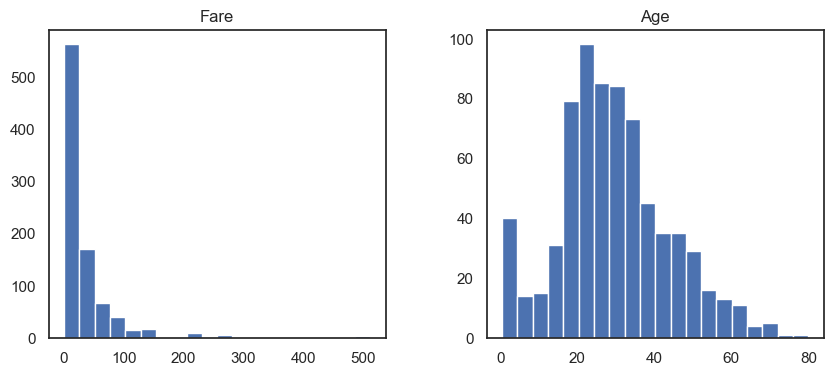

<Figure size 640x480 with 0 Axes>

In [8]:
# Display histograms for the two continuous variables, Fare and Age
train[['Fare', 'Age']].hist(figsize=(10, 4), bins=20, grid=False)
plt.figure()

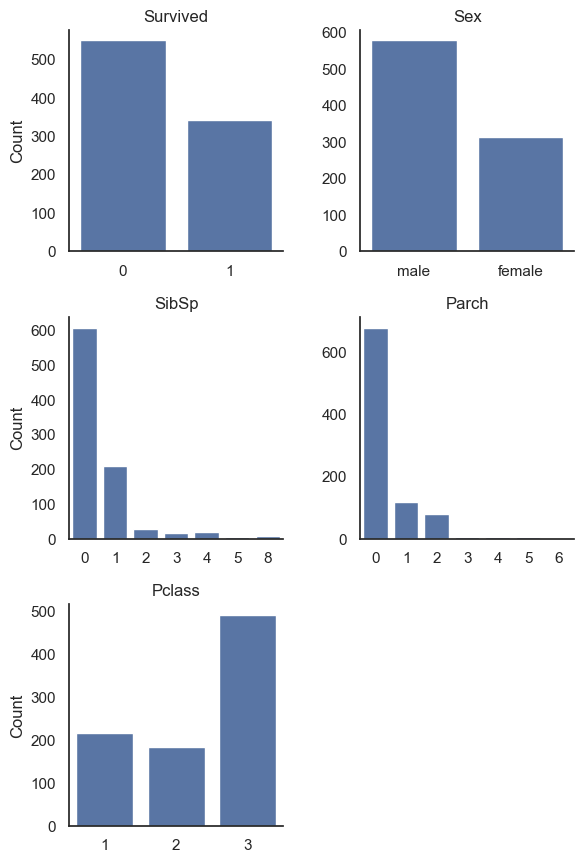

In [9]:
# Melt the data to long-form
melted_data = pd.melt(frame=train, value_vars=['Survived', 'Sex', 'SibSp', 'Parch', 'Pclass'])

# Function to handle plotting within FacetGrid
def custom_countplot(x, **kwargs):
    sns.countplot(x=x, **kwargs)

# Create the FacetGrid
g = sns.FacetGrid(data=melted_data, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(custom_countplot, 'value')

# Adjust the axis labels and titles
g.set_axis_labels(x_var="", y_var="Count")
g.set_titles(template="{col_name}")

# Show the plots
plt.show()

We also want to understand the relationships between variables. We can do this at a glance with a table of correlation coefficients, although this will only tell us about linear relationships:

In [10]:
# Create a temporary DataFrame with the Sex column converted to numeric
corr_df = train.copy()
corr_df['Sex'] = corr_df['Sex'].map(arg={'female': 0, 'male': 1}).astype(dtype=int)

# Drop the specified columns and compute the correlation matrix
corr_df.drop(columns=['Name', 'Embarked', 'PassengerId', 'Cabin', 'Ticket']).corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000


Here we see a strong relationship between 'SibSp' and 'Parch', which makes sense, since these are both measures of family size. The strong correlation we observe between 'Pclass' and 'Fare' also makes sense, given that upper class tickets tend to be more expensive. Women on the Titanic were more likely to have parent-child or sibling-spouse relationships, while men were more likely to have paid a higher fare.

Of greater relevance for our forecasting task, we observe a strong relationship between 'Survived' and 'Sex', and weaker relationships between 'Survived' and 'Pclass' and 'Fare'. Surprisingly, the relationship of 'Survived' to 'Age' and 'Parch' is quite weak.

Since 'Embarked' is categorical and not ordinal, we can't use a correlation coefficient to measure its relationships to other variables. Instead, we can group the data by 'Embarked' and compute the means of other variables for each group:

In [11]:
# Group by Embarked and summarize survival rate
corr_df.drop(columns=['Name', 'PassengerId', 'Cabin', 'Ticket']).groupby(by='Embarked').mean()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,0.553571,1.886905,0.565476,30.814769,0.386905,0.363095,59.954144
Q,0.389610,2.909091,0.532468,28.089286,0.428571,0.168831,13.276030
S,0.336957,2.350932,0.684783,29.445397,0.571429,0.413043,27.079812


Surprisingly, we see a significantly higher survival rate for embarkations from Cherbourg. This is probably due to confounding variables, such as the fact that Cherbourg passengers were more likely to be female and upper class and to have paid a higher fare. The survival rate for Queenstown is also higher than for Southampton even though Queenstown passengers were on average lower class and paid the lowest fares. This might be related to our sex variable, as Queenstown passengers were the most female. Queenstown is also where the crew embarked from, so we have to consider whether crew survived at a higher rate than other passengers. We can investigate this further by grouping the data by 'Embarked' and 'Pclass' and computing the mean 'Sex', 'Fare', and 'Survived' for each group:

In [12]:
# Group by Embarked and Pclass and summarize Sex, Fare, and Survival rate by mean
corr_df[['Embarked', 'Pclass', 'Sex', 'Fare', 'Survived']].groupby(by=['Embarked', 'Pclass']).mean()

Sex        Fare  Survived
Embarked Pclass                                
C        1       0.494118  104.718529  0.694118
         2       0.588235   25.358335  0.529412
         3       0.651515   11.214083  0.378788
Q        1       0.500000   90.000000  0.500000
         2       0.333333   12.350000  0.666667
         3       0.541667   11.183393  0.375000
S        1       0.622047   70.364862  0.582677
         2       0.591463   20.327439  0.463415
         3       0.750708   14.644083  0.189802

Sure enough, we find that departures from Cherbourg and Queenstown exhibit generally higher survival rates than departures from Southampton across all three social classes, but that sex and fare may explain a lot of the difference.

(Note that while the survival rates for first- and second-class passengers for Queenstown violate the pattern a bit, that's because there are only a few passengers in these groups. We can get more insight into the size of each group by using a contingency table, as shown below.)

In [13]:
# Create a contingency table indexing Survived against Pclass and Embarked
contingency_table = pd.crosstab(index=train['Survived'], columns=[train['Pclass'], train['Embarked']])
print(contingency_table)

Pclass     1         2          3         
Embarked   C  Q   S  C  Q   S   C   Q    S
Survived                                  
0         26  1  53  8  1  88  41  45  286
1         59  1  74  9  2  76  25  27   67


In general, we've found some evidence to support our hypothesis that 'Embarked' is independent of survival, but not enough to drop it from our model.

We've noticed some interesting linear relationships, but what about non-linear ones? For instance, I suspect that young children might have received preferential places in lifeboats, while there might have been less age-based preferential treatment among adults. We can visualize this with a violinplot:

<Axes: xlabel='Survived', ylabel='Age'>

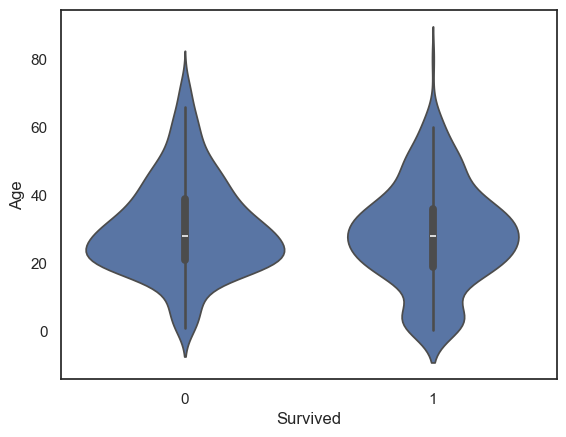

In [14]:
# violinplot of Age grouped by Survived
sns.violinplot(data=train,x="Survived", y="Age")

Sure enough, we find that the non-survival and survival groups had similar means and similar distributions. However, there are a few non-linear differences between them. As we hypothesized, young children under ten survived at higher rates. This is a non-linear relationship that we might want to capture in our model. However, we also observe a high mortality rate for young adults in their early twenties, while adults in the survival group actually skewed a bit older. That might be deference shown to the elderly, or it might be a function of lower-class passengers skewing younger, as we can observe with a violinplot of 'Pclass' against 'Age':

<Axes: xlabel='Pclass', ylabel='Age'>

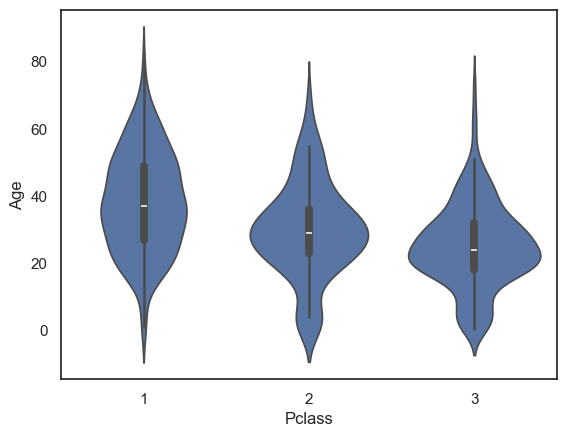

In [15]:
sns.violinplot(x='Pclass',y='Age',data=train)

Since we now know that young children survived preferentially, let's investigate whether their parents were given places in the lifeboats with them. We can do this by filtering the data for passengers over 18 years old and plotting 'Parch' against 'Survived':

<Axes: xlabel='Survived', ylabel='Parch'>

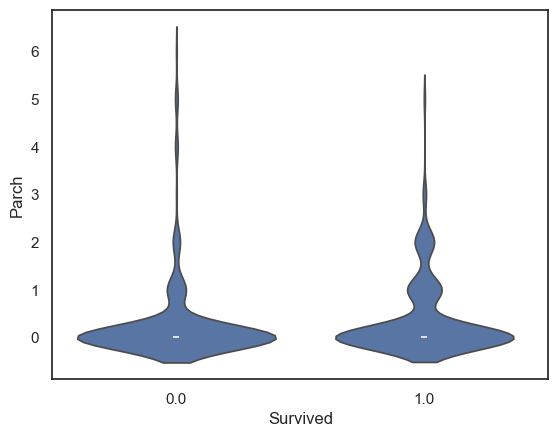

In [16]:
sns.violinplot(x='Survived',y='Parch',data=train.where(cond=train['Age'] > 18))

Interestingly, a few parents with very large families did not survive (perhaps because they had low SES?). However, we can clearly see better survival for parents with 1–3 children, which is consistent with our hypothesis that some parents may have received preferential treatment along with their children.

As a feature engineering exercise, let's also take a look at the 'Name', 'Cabin', and 'Ticket' variables to see what information we might be able to extract from these.

In [17]:
# Inspect head of train for Name, Cabin, and Ticket columns
train[['Name', 'Cabin', 'Ticket']].head(n=15)

,Name,Cabin,Ticket
0,"Braund, Mr. Owen Harris",NaN,A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,PC 17599
2,"Heikkinen, Miss. Laina",NaN,STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,113803
4,"Allen, Mr. William Henry",NaN,373450
5,"Moran, Mr. James",NaN,330877
6,"McCarthy, Mr. Timothy J",E46,17463
7,"Palsson, Master. Gosta Leonard",NaN,349909
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",NaN,347742
9,"Nasser, Mrs. Nicholas (Adele Achem)",NaN,237736


Several things to note here. First, many of the ticket numbers have prefixes that may or may not be meaningful for our prediction problem. We could also probably look for shared cabins or tickets to identify passengers who were traveling together. Ticket numbers are alphanumeric, with the letter perhaps indicating a level, and the number indicating the cabin number. These could perhaps be used as a measure of physical proximity to other passengers, which might be relevant for survival. As for the names, they generally include titles, which could be extracted as an indicator of age or social status, and they also parenthetically link wives to husbands, which we could use to infer family relationships. Such feature engineering might be helpful for improving our model or imputing missing data.

## Feature Engineering

Let's experiment with some feature engineering. For this step, we'll go ahead and consolidate test and train, since we'll need to do the same feature engineering for both datasets. We'll save the PassengerId column so we can resplit them when we're done. 

In [18]:
# Store PassengerId for test and train
train_passenger_ids = train['PassengerId']
test_passenger_ids = test['PassengerId']

# Consolidate test and train
all_data = pd.concat(objs=[train, test], axis=0, sort=False, ignore_index=True)

We'll extract the title from each passenger's name, the deck from each passenger's cabin number, and the prefix from each passenger's ticket.

In [19]:
# Extract the first character of Cabin and save as Deck
all_data['Deck'] = all_data['Cabin'].str[0]

# Get value counts for Deck in both train and test
all_data['Deck'].value_counts(dropna=True)

Deck
C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: count, dtype: int64

The Deck feature is promising, though the many missing values may reduce its usefulness.

The Titanic had decks A-G, with A being the uppermost. I'd like to try making this an ordinal variable, since the decks can be ordered top to bottom. Cabin T, with only one passenger, was apparently on the boat deck, so we'll make that Deck 1. After concluding this mapping, let's see if our ordinal variable has any relationship to other ordinal variables:

In [20]:
# Map Deck to dictionary
deck_map = {
    'T' : 1,
    'A' : 2,
    'B' : 3,
    'C' : 4,
    'D' : 5,
    'E' : 6,
    'F' : 7,
    'G' : 8
}

# Map deck_map to Deck in train and test
all_data['Deck'] = all_data['Deck'].map(arg=deck_map).astype(dtype='Int64')

# Group by Deck and summarize mean Fare and Pclass
print(all_data[['Deck', 'Fare', 'Pclass']].groupby(by='Deck').mean())

            Fare    Pclass
Deck                      
1      35.500000  1.000000
2      41.244314  1.000000
3     122.383078  1.000000
4     107.926598  1.000000
5      53.007339  1.130435
6      54.564634  1.243902
7      18.079367  2.380952
8      14.205000  3.000000


If our ordinal ranking is correct, we should see a strong negative correlation between Deck and Pclass, and a strong negative correlation between Deck and Fare. We do indeed see a strong relationship with Pclass, with the first four decks exclusive to upper-class people. However, we see a weaker relationship with Fare. The luxury berths may have been located on the third and fourth decks, with the top decks consisting of more standard cabins. It is tempting to rearrange the deck order to reflect this, but we should be careful about introducing our own biases into the model. We'll leave the deck order as is.

It's possible that we can impute missing values for Deck by assuming that passengers who shared the same ticket number stayed on the same deck. Let's see if this is the case:

In [21]:
# Group passengers who shared a Ticket and summarize unique values for Deck
ticket_decks = all_data[['Ticket', 'Deck']].groupby(by='Ticket').nunique()

# Sort by number of unique Deck values descending and print the rows
print(ticket_decks.sort_values(by='Deck', ascending=False).head(n=10))

          Deck
Ticket        
110465       2
PC 17485     2
110152       1
34218        1
248734       1
2543         1
2654         1
2655         1
2668         1
27042        1


There are two cases where passengers with a shared ticket stayed on different decks, but these seem to be exceptions to the rule. We can use this information to impute missing values for Deck.

In [22]:
# Count missing values for Deck
print(all_data['Deck'].isna().sum())

# Sort dataframe by Ticket, Deck
all_data.sort_values(by=['Ticket', 'Deck'], inplace=True)

# Group by Ticket and fill down and then up Deck for each group
all_data['Deck'] = all_data.groupby(by='Ticket')['Deck'].ffill()

# Count missing values for Deck
print(all_data['Deck'].isna().sum())

1014
998


Unfortunately, this reduces the number of missing values only very modestly.

Let's look next at ticket prefixes. For starters, we extract the prefixes and count the unique values:

In [23]:
# If no space exists in Ticket column, TicketPrefix is 'NoPrefix'
# Else, extract anything before a space in the Ticket column and save as TicketPrefix
all_data['TicketPrefix'] = all_data['Ticket'].apply(func=lambda x: 'NoPrefix' if ' ' not in x else x.split(' ')[0])

# Standardize TicketPrefix
all_data['TicketPrefix'] = all_data['TicketPrefix'].str.replace(pat='.', repl='')
all_data['TicketPrefix'] = all_data['TicketPrefix'].str.upper()
all_data['TicketPrefix'] = all_data['TicketPrefix'].str.replace(pat='STON', repl='SOTON')
all_data['TicketPrefix'] = all_data['TicketPrefix'].str.replace(pat='A/4', repl='A4')
all_data['TicketPrefix'] = all_data['TicketPrefix'].str.replace(pat='A/5', repl='A5')

# Get value counts for TicketPrefix
all_data['TicketPrefix'].value_counts(dropna=True)

TicketPrefix
NOPREFIX    961
PC           92
CA           68
A5           28
SOTON/OQ     25
SC/PARIS     19
W/C          15
SOTON/O      14
A4           10
SOTON/O2     10
FCC           9
C             8
SO/PP         7
SOC           7
SC/AH         5
PP            4
FC            3
SC            2
SW/PP         2
WEP           2
SC/A4         2
P/PP          2
WE/P          2
SOP           1
SP            1
A             1
SC/A3         1
LP            1
SCO/W         1
SO/C          1
FA            1
CA/SOTON      1
AQ/4          1
AQ/3          1
A/S           1
Name: count, dtype: int64

Unfortunately, Even after some standardization, this feature is a bit of a mess. We suspect that the prefixes may indicate something about origin and destination, since we recognize "PARIS" and "SOTON" as locations. Many of the prefixes contain two values separated by slashes. We'll select a few high-frequency values to one-hot encode, and then to bin the rest into "NOPREFIX" or, implicitly, "OTHER".

In [24]:
# Create one-hot encoded features if TicketPrefix contains CA, PC, A5, A4, SOTON, PARIS, or NOPREFIX
all_data['TicketPrefix_CA'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'CA' in x else 0)
all_data['TicketPrefix_PC'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'PC' in x else 0)
all_data['TicketPrefix_A5'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'A5' in x else 0)
all_data['TicketPrefix_SOTON'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'SOTON' in x else 0)
all_data['TicketPrefix_PARIS'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'PARIS' in x else 0)
all_data['TicketPrefix_NoPrefix'] = all_data['TicketPrefix'].apply(lambda x: 1 if 'NOPREFIX' in x else 0)

# Count sums of one-hot encoded features
print(all_data[['TicketPrefix_CA', 'TicketPrefix_PC', 'TicketPrefix_A5', 'TicketPrefix_SOTON', 'TicketPrefix_PARIS', 'TicketPrefix_NoPrefix']].sum())

TicketPrefix_CA           69
TicketPrefix_PC           92
TicketPrefix_A5           28
TicketPrefix_SOTON        50
TicketPrefix_PARIS        19
TicketPrefix_NoPrefix    961
dtype: int64


Finally, let's do a little feature engineering on the Name variable, which contains information about title, passenger name, and spouse's name. We'll try to separate these three elements.

In [25]:
# Extract phrase that follows ', ' and ends with '.' in Name and save as Title
all_data['Title'] = all_data['Name'].str.split(pat=', ', expand=True)[1].str.split(pat='.', expand=True)[0]

# Delete pattern starting with ' ' and ending with '.' from Name
all_data['Name'] = all_data['Name'].str.replace(pat=' .*\.', repl='', regex=True)

# Extract text inside parentheses and save as PassengerName only for rows with Title=='Mrs'
all_data.loc[all_data['Title'] == 'Mrs', 'PassengerName'] = all_data.loc[all_data['Title'] == 'Mrs', 'Name'].str.extract(pat='\\((.*)\\)').iloc[:, 0]

# Extract text before ' (' to SpouseName only for rows with Title=='Mrs'
all_data.loc[all_data['Title'] == 'Mrs', 'SpouseName'] = all_data.loc[all_data['Title'] == 'Mrs', 'Name'].str.split(pat=' \\(', expand=True).iloc[:, 0]

# Set PassengerName to Name for rows with NaN PassengerName
all_data['PassengerName'] = all_data['PassengerName'].fillna(value=all_data['Name'])

# Map all non-NA values of SpouseName to corresponding PassengerName
spouse_map = {row.SpouseName: row.PassengerName for _, row in all_data[['SpouseName', 'PassengerName']].dropna().iterrows()}
reversed_spouse_map = {value: key for key, value in spouse_map.items()}
spouse_map.update(reversed_spouse_map)

# Match SpouseName key in spouse_map to PassengerName in all_data and save corresponding value as SpouseName
all_data['SpouseName'] = all_data['PassengerName'].map(arg=spouse_map)

We can use our spouse_map to create a SpouseAge feature, which might be useful for imputation of Age.

In [26]:
# Create age_map of PassengerName to corresponding Age
age_map = {passenger : age for passenger, age in all_data[['PassengerName', 'Age']].dropna().values}

# Use age_map to get SpouseAge
all_data['SpouseAge'] = all_data['SpouseName'].map(arg=age_map)

# Print number of missing values for Age in rows where SpouseAge is not null
print("Number of missing values for Age in rows where SpouseAge is not null: " + str(object=all_data.loc[~all_data['SpouseAge'].isna(), 'Age'].isna().sum()))

# Get mean difference between Age and SpouseAge where Title is 'Mrs'
# And count number of rows where Title is 'Mrs' and Age and SpouseAge are not null
age_diff_mrs = (all_data.loc[all_data['Title'] == 'Mrs', 'Age'] - all_data.loc[all_data['Title'] == 'Mrs', 'SpouseAge']).mean()
count_mrs = all_data.loc[all_data['Title'] == 'Mrs', ['Age', 'SpouseAge']].notnull().all(axis=1).sum()
age_diff_mr = (all_data.loc[all_data['Title'] != 'Mrs', 'Age'] - all_data.loc[all_data['Title'] != 'Mrs', 'SpouseAge']).mean()
count_mr = all_data.loc[all_data['Title'] != 'Mrs', ['Age', 'SpouseAge']].notnull().all(axis=1).sum()

mean_age_diff = (age_diff_mr * count_mr - age_diff_mrs * count_mrs) / (count_mrs + count_mr)
print("Mean difference between male Age and female SpouseAge: " + str(object=mean_age_diff))

# Fill missing Age values where title is 'Mrs' with Age - mean_age_diff
all_data.loc[(all_data['Title'] == 'Mrs') & (all_data['Age'].isna()), 'Age'] = all_data.loc[(all_data['Title'] == 'Mrs') & (all_data['Age'].isna()), 'SpouseAge'] - mean_age_diff

# Fill missing Age values where title is not 'Mrs' with SpouseAge + mean_age_diff
all_data.loc[(all_data['Title'] != 'Mrs') & (all_data['Age'].isna()), 'Age'] = all_data.loc[(all_data['Title'] != 'Mrs') & (all_data['Age'].isna()), 'SpouseAge'] + mean_age_diff

if all_data.loc[~all_data['SpouseAge'].isna(), 'Age'].isna().sum() == 0:
    print("Missing Age values imputed.")
else:
    print("Imputation failed.")

Number of missing values for Age in rows where SpouseAge is not null: 6
Mean difference between male Age and female SpouseAge: 4.008982035928144
Missing Age values imputed.


There are unfortunately only a few cases where this is possible, but we perform the imputation anyway. Let's see if we have better luck using our spouse_map to impute missing values for Deck:

In [27]:
# Print number of missing values for Deck in rows where SpouseName is not null
print("Number of missing values for Deck in rows where SpouseName is not null: " + str(object=all_data.loc[~all_data['SpouseName'].isna(), 'Cabin'].isna().sum()))

# Create deck_map of PassengerName to corresponding Deck
deck_map = {passenger : deck for passenger, deck in all_data[['PassengerName', 'Deck']].dropna().values}

# Use deck_map to get SpouseDeck
all_data['SpouseDeck'] = all_data['SpouseName'].map(arg=deck_map)

# Print number of missing values for Deck in rows where SpouseDeck is not null
print("Number of values we can impute: " + str(object=all_data.loc[~all_data['SpouseDeck'].isna(), 'Deck'].isna().sum()))

# Fill any missing values of Deck with SpouseDeck
all_data['Deck'] = all_data['Deck'].fillna(value=all_data['SpouseDeck'])

Number of missing values for Deck in rows where SpouseName is not null: 174
Number of values we can impute: 0


Unfortunately, there are no missing Deck values we can impute with information from the spouse.

Finally, let's work on our Title feature. Counting the unique values, we find that many have only a few occurrences:

In [28]:
# Get value counts of unique values in Title
print(all_data['Title'].value_counts(dropna=False))

Title
Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Dona              1
Don               1
Sir               1
Jonkheer          1
Mme               1
the Countess      1
Lady              1
Capt              1
Name: count, dtype: int64


Let's try to keep each group larger than 20 observations by binning the lowest-frequency titles. Fortunately, most of these fit naturally into their own category, which we might characterize as being comprised of 'Elite' titles. The exceptions are 'Ms' and 'Mlle', which we'll bin with 'Miss', and 'Mme', which we'll bin with 'Mrs'.

In [29]:
title_mapping = {
    'Capt': 'Elite',
    'Col': 'Elite',
    'Don': 'Elite',
    'Dona': 'Elite',
    'Dr': 'Elite',
    'Jonkheer': 'Elite',
    'Lady': 'Elite',
    'Major': 'Elite',
    'Master': 'Master',
    'Miss': 'Miss',
    'Mlle': 'Miss',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Miss',
    'Rev': 'Elite',
    'Sir': 'Elite',
    'the Countess': 'Elite',
    'Elite': 'Elite'
}

# Replace the titles based on the mapping
all_data['Title'] = all_data['Title'].map(arg=title_mapping)

# Get value counts of unique values in Title
print(all_data['Title'].value_counts(dropna=False))

Title
Mr        757
Miss      264
Mrs       198
Master     61
Elite      29
Name: count, dtype: int64


We have constructed a few promising features, and we have managed to impute a few values. Let's re-split our data into the original train and test sets, using the PassengerId column to do so.

In [30]:
# split all_data into train and test based on train_passenger_ids and test_passenger_ids
train = all_data.loc[all_data['PassengerId'].isin(values=train_passenger_ids), :]
test = all_data.loc[all_data['PassengerId'].isin(values=test_passenger_ids), :]

## Modeling

Now that we've learned some things about our data, we can begin to build a model to predict survival. We begin by installing the additional libraries we will need for our analysis, including scikit-learn, matplotlib, xgboost, seaborn, and numpy. To install these libraries, use `pip install scikit-learn matplotlib xgboost seaborn numpy`.

Next, we need to define a function to preprocess our data for modeling. First, we'll drop the columns we don't plan to use for our analysis: 'Name', 'Cabin', 'Ticket', and 'PassengerId'. Next, since some ML models can't handle missing values, we'll supply missing ages by substituting the median for missing Age and Fare and the mode for missing 'Embarked', while also creating new binary variables to mark which values were missing. Since 'Embarked' is a non-ordinal categorical variable, we'll also need to use one-hot encoding so we can model this variable alongside our ordinal numerical variables. This involves converting the 'Embarked' columns to two binary columns, 'S' and 'Q'. (A value of 'C' will be represented as [0, 0] across the new columns.)

Next, we'll separate dependent from independent variables and use scikit-learn's `train_test_split` function to split the training data into `pretrain` and `validation` sets. We'll use these for model selection and tuning hyperparameters. We'll put 30% of our dataset into the `validation` set. We'll also use scikit-learn's `StandardScaler` to standardize the data (centering the variables around zero and equalizing their variance), which will help our models converge faster. For consistency when using our models to predict the test data, we'll also standardize the test data using the same scaler.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import random

# Set seed for reproducibility
seed = 42
np.random.seed(seed=seed)
random.seed(a=seed)

# Define columns
sparse_impute_continuous = ['Fare']
sparse_impute_categorical = ['Embarked']
impute_columns = ['Age', 'Deck']
numerical_columns = ['Pclass', 'SibSp', 'Parch']
categorical_columns = ['Sex', 'Title']
drop_columns = ['Name', 'Cabin', 'Ticket', 'PassengerId', 'TicketPrefix',
                'Title', 'PassengerName', 'SpouseName', 'SpouseAge',
                'SpouseDeck']

# Split the data
pretrain, validation = train_test_split(train, test_size=0.3, random_state=seed)

# Separate features and target
x_pretrain = pretrain.drop(labels=['Survived'], axis=1)
y_pretrain = pretrain['Survived']
x_validation = validation.drop(labels=['Survived'], axis=1)
y_validation = validation['Survived']

# Define transformers
transformers = [
    ('drop', 'drop', drop_columns),
    ('si_cont', Pipeline(steps=[
        ('impute', KNNImputer()),
        ('scale', StandardScaler())
    ]), sparse_impute_continuous),
    ('si_cat', Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first'))
    ]), sparse_impute_categorical),
    ('imp', Pipeline(steps=[
        ('impute', KNNImputer(add_indicator=True)),
        ('scale', StandardScaler())
    ]), impute_columns),
    ('num', Pipeline(steps=[
        ('scale', StandardScaler())
    ]), numerical_columns),
    ('cat', Pipeline(steps=[
        ('encode', OneHotEncoder(drop='first'))
    ]), categorical_columns)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Debug: Transform the pretrain set using the preprocessor
x_pretrain_transformed = preprocessor.fit_transform(X=x_pretrain)

# Inspect the transformed data
columns = preprocessor.get_feature_names_out()
number_of_features = len(columns)
print("Number of features: " + str(object=number_of_features))
print(columns)

TypeError: cannot unpack non-iterable SimpleImputer object

We'll try several models and compare their performance using the `accuracy_score` metric provided by scikit-learn. Accuracy is defined as the percentage of predictions we get correct. In some contexts it might be more appropriate to use other metrics, such as precision, recall, or F1 score, but for this problem, accuracy is a reasonable metric.

Since our accuracy score requires binary predictions (1 or 0), whereas our models are mostly returning probabilities (between 0 and 1), we'll need to convert the probabilities to binary predictions. We'll do this by using a threshold of 0.5. If the probability is greater than 0.5, we'll predict 1, and if it's less than 0.5, we'll predict 0.

In [60]:
from sklearn.metrics import accuracy_score, make_scorer

# Define a custom scoring function with 0.5 prediction threshold
def thresholded_accuracy(y_true, y_pred) -> float:
    # Apply thresholding
    y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
    # Calculate and return accuracy
    return accuracy_score(y_true=y_true, y_pred=y_pred)

# Create a custom scorer
custom_scorer = make_scorer(
        score_func=thresholded_accuracy,
        greater_is_better=True,
        needs_threshold=True
    )

### Linear and Logistic Regression Models

Let's start with simple linear and logistic regression models. Since we have a sizable number of features—particularly one-hot encoded variables—for such a small dataset, there's a real risk of overfitting. To prevent overfitting and ensure that our model generalizes well to unseen data, we'll use regularization to penalize. For linear regression, we'll use scikit-learn's `RidgeCV` class, for logistic regression, we'll use the `LogisticRegressionCV` class. Both of these classes use cross-validation to tune a penalty parameter. We'll use the `fit` method to fit the model to the training data.

In [61]:
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegressionCV

# Create and fit a pipeline for Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use RidgeCV to find the best alpha using cross-validation
    ('model', RidgeCV(alphas=np.logspace(start=-6, stop=6, num=13)))
])
ridge_pipeline.fit(X=x_pretrain, y=y_pretrain);

# Create and fit a pipeline for Lasso regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use LassoCV to find the best alpha using cross-validation
    ('model', LassoCV(alphas=np.logspace(start=-6, stop=6, num=13), cv=5, random_state=seed))
])
lasso_pipeline.fit(X=x_pretrain, y=y_pretrain);

# Create and fit a pipeline for Logistic regression with CV for C
logisticCV_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use LogisticRegressionCV to find the best C using cross-validation
    ('model', LogisticRegressionCV(Cs=10, max_iter=1000, cv=5, random_state=seed))
])
logisticCV_pipeline.fit(X=x_pretrain, y=y_pretrain);

Let's inspect the model intercepts and coefficients:

In [62]:
# Get the models from the pipelines
ridge_model = ridge_pipeline.named_steps['model']
lasso_model = lasso_pipeline.named_steps['model']
logisticCV_model = logisticCV_pipeline.named_steps['model']

# Extract coefficients and intercepts from each model
ridge_coefficients = ridge_model.coef_
ridge_intercept = ridge_model.intercept_

lasso_coefficients = lasso_model.coef_
lasso_intercept = lasso_model.intercept_

logisticCV_coefficients = logisticCV_model.coef_[0]  # logistic regression coef is 2D
logisticCV_intercept = logisticCV_model.intercept_

# Combine the data into a dictionary
data = {
    "Features": ["Intercept"] + list(columns),
    "Ridge": [ridge_intercept] + list(ridge_coefficients),
    "Lasso": [lasso_intercept] + list(lasso_coefficients),
    "LogisticCV": [logisticCV_intercept] + list(logisticCV_coefficients)
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data=data)

# Display the DataFrame
df


,Features,Ridge,Lasso,LogisticCV
0,Intercept,0.694689,0.739605,[0.9017870700295924]
1,imp__Age,-0.045135,-0.043061,-0.360371
2,imp__Fare,0.048675,0.043696,0.284122
3,imp__Deck,0.005989,0.002735,0.073087
4,num__Pclass,-0.121340,-0.116343,-0.982321
5,num__SibSp,-0.081586,-0.079004,-0.577999
6,num__Parch,-0.020823,-0.017854,-0.122187
7,cat__Sex_male,-0.429562,-0.510961,-2.01251
8,cat__Embarked_Q,-0.002224,0.000000,0.047933
9,cat__Embarked_S,-0.050236,-0.035706,-0.293755


Inspecting the models reveals that Sex is the most important variable, and the (notably sex-correlated) titles 'Mr' and 'Master' are also influential. The title 'Mrs' is more imporant than 'Miss'. The ticket prefix related to SOTON is also significant. Pclass is a more distant runner-up.

As we learned during data exploration, Age has a nonlinear relationship to Survived. Let's try some more sophisticated models that can capture the nonlinearity.

### Decision Tree Models

Let's start with a naive decision tree model, and then try some ensemble models. On many data science problems, Extra Trees and Random Forest models are among the top performers. These are basically ensemble models that combine many decision trees.

A decision tree regressor is a tree-like model where decisions are made based on asking a series of questions. It is a supervised learning algorithm that can be used for both classification and regression tasks. The algorithm tries to split the data into subsets based on the feature values. This is done recursively in a greedy manner by choosing the split that results in the largest reduction in variance (for regression) or in impurity (for classification, using metrics like Gini impurity or entropy). The algorithm stops when it reaches a predefined stopping criterion, such as when the tree reaches a certain depth, or when the number of samples in a node falls below a certain threshold. These "hyperparameters" can be tuned to improve the model's performance.

In the following code, we will use scikit-learn's `DecisionTreeClassifier` class to fit a decision tree model to the training data and `GridSearchCV` to tune the hyperparameters. We'll use the `fit` method to fit the model to the training data.

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the full pipeline with preprocessing and model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__max_depth': list(range(1, number_of_features)),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 5),
    'model__max_features': ['sqrt', 'log2']
}

# Use RandomizedSearchCV to search for the best hyperparameters
dt_search = RandomizedSearchCV(
        estimator=dt_pipeline, 
        param_distributions=param_distributions, 
        scoring=custom_scorer, 
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
dt_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = dt_search.best_params_

# Get the best estimator
best_dt = dt_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__min_samples_split': 3, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 8}


One of the advantages of a decision tree model is its interpretability. Let's visualize the decision tree:

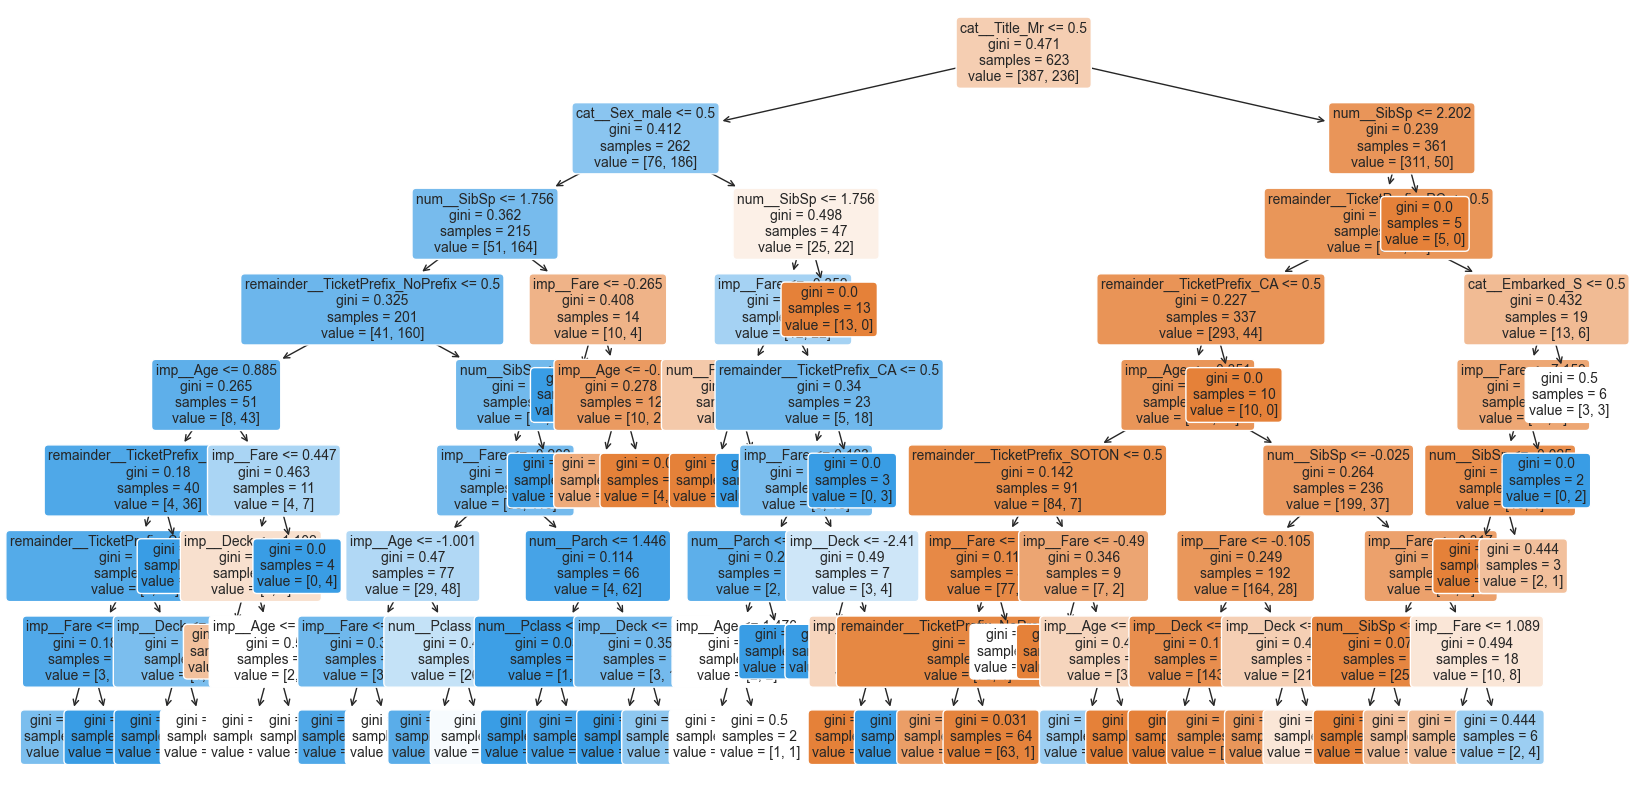

In [64]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(decision_tree=best_dt['model'], feature_names=columns, filled=True, rounded=True, fontsize=10)
plt.show()

The title 'Mr' is the most important variable, followed by 'SibSp' and 'Age'. The SOTON ticket prefix is also important. The model captures the nonlinear relationship between Age and Survived that we observed during data exploration, which may make this more powerful than our linear and logistic models.

Now let's try some ensemble models. A random forest is an ensemble method that creates a 'forest' of decision trees. Each tree is trained on a subset of the data and gives a prediction. The random forest aggregates these predictions to produce a final result. Random forests use bootstrap aggregating (or bagging) to sub-sample the data used to train each tree, introducing randomness. Features for splitting nodes are also selected from a random subset of the available features. As with decision trees, the stopping criteria can be tuned to improve the model's performance.

In [65]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the RandomForest pipeline with preprocessing
rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': list(range(1, number_of_features)),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy']
}

# Use RandomizedSearchCV to search for the best hyperparameters
rfc_search = RandomizedSearchCV(
        estimator=rfc_pipeline,
        param_distributions=param_distributions,
        scoring=custom_scorer,
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
rfc_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = rfc_search.best_params_

# Get the best estimator and make predictions
best_rfc = rfc_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__bootstrap': False, 'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 18, 'model__n_estimators': 132}


There's unfortunately quite a long training time for this model because we have so many features. Let's inspect the fitted model to see the feature importances:

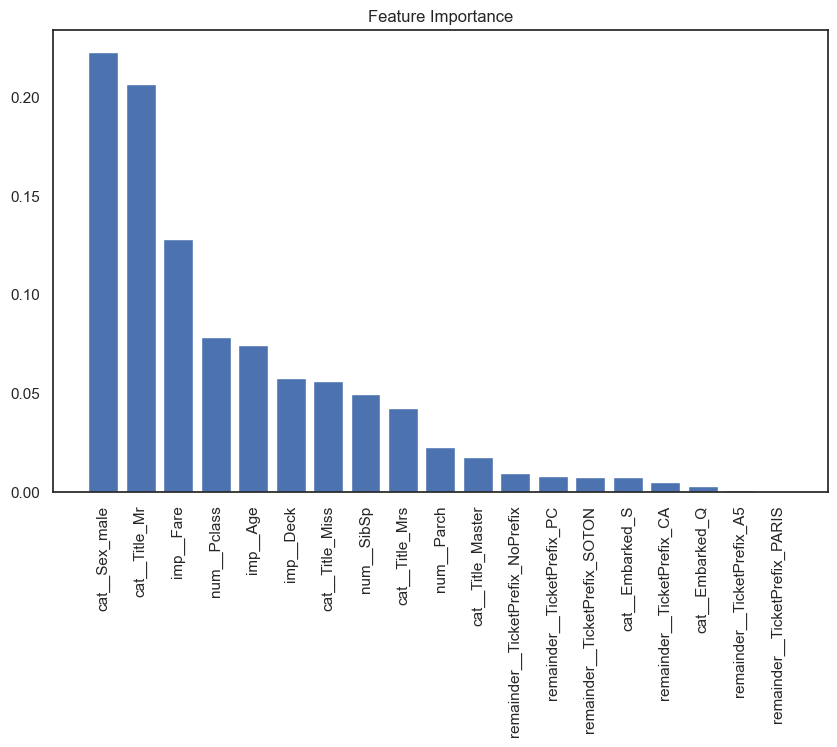

In [66]:
# Get feature importances
importances = best_rfc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_rfc.named_steps['preprocessor'].get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(a=importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title(label="Feature Importance")
plt.bar(x=range(len(names)), height=importances[indices])

# Add feature names as x-axis labels
plt.xticks(ticks=range(len(names)), labels=names, rotation=90)

# Display the plot
plt.show()

The 'Mr' title remains the most important variable, followed by 'Sex'. Interestingly, in this model, Fare leapfrogs into third place, followed by Pclass. The SOTON ticket prefix falls almost completely out of the model.

Let's see if an Extra Trees model can help us mitigate overfitting. The Extra Trees Regressor model, also known as Extremely Randomized Trees, is similar to a Random Forest model, but it uses a random threshold for each feature rather than finding the best possible threshold. This results in a higher variance for the predictions, but a lower bias, which can improve the model's performance.

In [67]:
from sklearn.ensemble import ExtraTreesClassifier

# Define the pipeline incorporating the preprocessor and the classifier
etc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=seed))
])

# Adjust the parameter distributions to account for the pipeline
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': ['log2', 'sqrt'],
    'model__criterion': ['entropy', 'gini'],
    'model__max_depth': list(range(1, number_of_features)),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20)
}

# Run the randomized search
etc_search = RandomizedSearchCV(
    estimator=etc_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model to the unprocessed data directly
etc_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the search
best_params = etc_search.best_params_

# Set the clf to the best combination of parameters
best_etc = etc_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__criterion': 'entropy', 'model__max_depth': 17, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 17, 'model__n_estimators': 464}


Let's inspect this model.

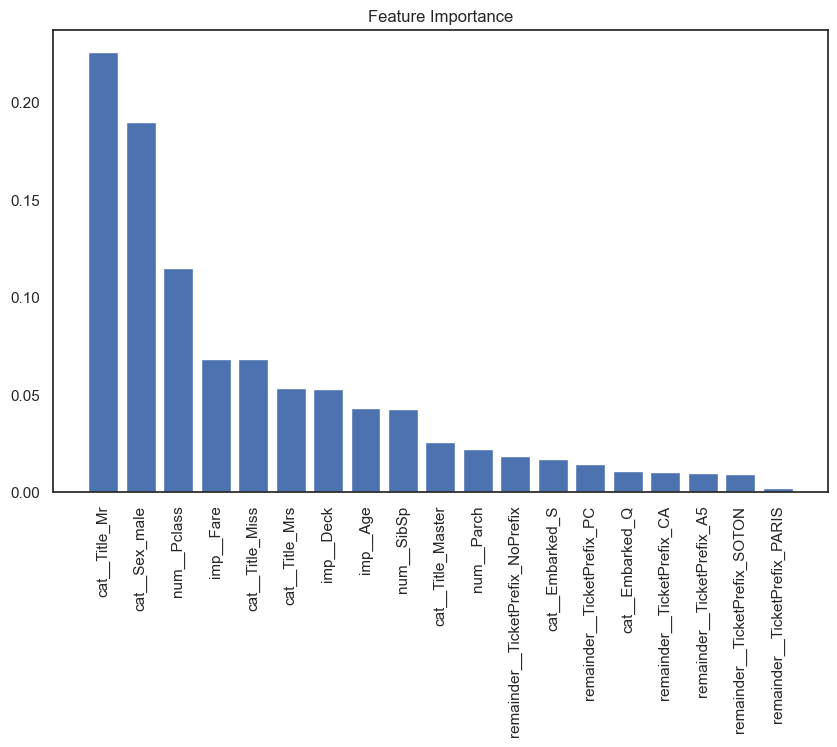

In [68]:
# Get feature importances
importances = best_etc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_etc.named_steps['preprocessor'].get_feature_names_out()

# Ensure that the number of features matches
assert len(features) == len(importances), "Mismatch between number of features and importances"

# Sort feature importances in descending order
indices = np.argsort(a=importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title(label="Feature Importance")
plt.bar(x=range(len(names)), height=importances[indices])

# Add feature names as x-axis labels
plt.xticks(ticks=range(len(names)), labels=names, rotation=90)

# Display the plot
plt.show()

The importances in this model are similar to RandomForest, though interestingly, the missing indicator for Deck has risen to fourth place. I suspect this is noise in the model, but it's also possible that the reason these passengers' decks are missing from the dataset is because they were lower class and their lives are less documented, and the model is picking up some informational signal from that.

### Gradient Boosting Models

[XGBoost](https://en.wikipedia.org/wiki/XGBoost) is an open-source gradient boosting framework. It is a supervised learning algorithm that can be used for both classification and regression tasks. It is an ensemble model that combines many weak learners (in this case, decision trees) to produce a strong learner. It uses gradient boosting to minimize a loss function when adding new models to the ensemble. The loss function is typically a measure of error, such as mean squared error for regression or cross-entropy for classification. The algorithm starts with an initial model, then iteratively adds new models to the ensemble, each time minimizing the loss function. The new models are added in a greedy manner, so that the loss function is minimized at each step. The algorithm stops when it reaches a predefined stopping criterion, such as when the number of models reaches a certain threshold, or when the loss function falls below a certain threshold.

In [69]:
import xgboost as xgb
from scipy.stats import randint, uniform

# Define the pipeline incorporating the preprocessor and the classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(objective='binary:logistic', random_state=seed, use_label_encoder=False, eval_metric='logloss'))
])

# Define parameter distributions
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(1, number_of_features),
    'model__subsample': uniform(0.1, 0.5),
    'model__colsample_bytree': uniform(0.1, 0.2)
}

# Run the randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model
xgb_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = xgb_search.best_params_

# Fit the best algorithm to the data
best_xgb = xgb_search.best_estimator_

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)

c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Best hyperparameters:
 {'model__colsample_bytree': 0.1940601268892077, 'model__learning_rate': 0.10834231408948429, 'model__max_depth': 11, 'model__n_estimators': 244, 'model__subsample': 0.4991725624922756}


This model trains much faster than either RandomForest or ExtraTrees; XGBoost is wonderfully optimized. Let's inspect the model:

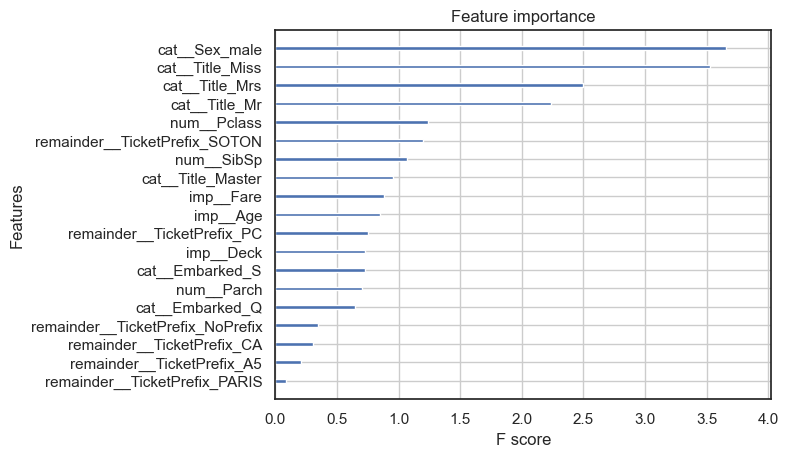

In [70]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Map 'f0', 'f1', ... to the actual feature names
mapper = {f'f{i}': feature for i, feature in enumerate(iterable=columns)}

# Plot feature importance with actual feature names
ax = plot_importance(booster=best_xgb.named_steps['model'], importance_type='gain', show_values=False)
ax.set_yticklabels([mapper.get(ylabel.get_text()) for ylabel in ax.get_yticklabels()])
plt.show()

We see a similar set of variables rise to the top, including the title 'Mr', 'Sex', the title 'Mrs', 'Pclass', and 'Fare'.

Now let's perform some cross-validation scoring to select a model from the models we've trained.

## Model Selection

To avoid information leakage from the validation set (which will be used to obtain a final, unbiased estimate of model performance), we will use mean accuracy from cross-validation on the training set as our metric for model selection.

In [71]:
from sklearn.model_selection import cross_val_score

# Nested CV function
def get_nested_cv_scores(pipeline, X, y, cv=5, scoring=None):
    scores = cross_val_score(estimator=pipeline, X=X, y=y, cv=cv, scoring=scoring)
    return {"mean": scores.mean(), "std": scores.std()}

# List of models to evaluate
pipelines = {
    "Ridge Regression": ridge_pipeline,
    "Lasso Regression": lasso_pipeline,
    "Logistic Regression": logisticCV_pipeline,
    "Decision Tree": best_dt,
    "Random Forest": best_rfc,
    "Extra Trees": best_etc,
    "XGBoost": best_xgb
}

# Evaluate each model
results = {}
for name, pipeline in pipelines.items():
    if name in ["Ridge Regression", "Lasso Regression"]:
        results[name] = get_nested_cv_scores(pipeline=pipeline, X=x_pretrain, y=y_pretrain, scoring=custom_scorer)
    else:
        results[name] = get_nested_cv_scores(pipeline=pipeline, X=x_pretrain, y=y_pretrain)

# Convert results to a DataFrame
results_df = pd.DataFrame(data=results).transpose()

# Calculate mean minus std and save in new column
results_df['mean_minus_std'] = results_df['mean'] - results_df['std']

# Save best-performing model object as best_model
best_model = pipelines[results_df['mean_minus_std'].idxmax()]

# Display the results
print(results_df)

c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead

                         mean       std  mean_minus_std
Ridge Regression     0.831497  0.016432        0.815065
Lasso Regression     0.833123  0.016575        0.816548
Logistic Regression  0.820310  0.025114        0.795196
Decision Tree        0.825019  0.016533        0.808486
Random Forest        0.841135  0.021410        0.819725
Extra Trees          0.844361  0.022638        0.821724
XGBoost              0.847587  0.027888        0.819699


To select the best-performing model, we penalize the mean performance by subtracting the standard deviation of the performance across the folds. This is because we want to select a model that performs well on average, but also one whose performance is stable across different subsets of the data. The winner is ExtraTrees, with a penalized mean accuracy of around 83% and surprisingly low variability in cross-validation.

## Validation

But these are cross-validation scores, which are biased estimates of model performance. To get an unbiased estimate of model performance, we need to evaluate the model on the validation set. Let's do that now.

We'll use the best-performing model, ExtraTrees, to predict the validation data. We'll then use the `accuracy_score` function to compute the accuracy of our final predictions.

In [72]:
from scipy.stats import t

# Use the best model to get cross-validation scores on the validation set 
best_validation_score = get_nested_cv_scores(pipeline=best_model, X=x_validation, y=y_validation)

# Calculate 95% confidence interval for etc_validation_scores
n = 5
t_95 = t.ppf(q=0.975, df=n-1)
margin_of_error = t_95 * (best_validation_score['std'] / np.sqrt(n))
lower_bound = best_validation_score['mean'] - margin_of_error
upper_bound = best_validation_score['mean'] + margin_of_error

print(best_validation_score)
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

{'mean': 0.7983927323549965, 'std': 0.015456230664932739}
95% Confidence Interval: (0.7792012871904165, 0.8175841775195766)


Our prize ExtraTrees model seemingly generalizes quite well to the out-of-sample data, scoring 83%, with a standard deviation of around 2%. It's likely we can expect a score in the range of 80–86% on our final submission.

## Final Training Phase

Let's re-train the best-performing model on the full training dataset and use it to predict the test data and submit our results to Kaggle.

In [73]:
# Separate features and target for the complete train and test sets
x_train = train.drop(labels=['Survived'], axis=1)
y_train = train['Survived']
x_test = test

# Fit the best XGBoost algorithm to the complete training data
best_model.fit(X=x_train, y=y_train)

# Make predictions on the test set
best_prediction = best_model.predict(X=x_test).astype(dtype=int)

# Convert the predictions to a Pandas DataFrame with PassengerId and Survived columns
submission = pd.DataFrame(data={
        "PassengerId": test["PassengerId"],
        "Survived": best_prediction
    })

# Write the submission DataFrame to a CSV file
submission.to_csv(path_or_buf='submission.csv', index=False)

Our final Kaggle score of 0.7847 is somewhat below the low end of our 95% confidence interval range. This suggests either that we have some information leakage somewhere or that the test data exhibits systematic bias or distribution shift. I **think** I've guarded well against leakage, so in the absence of other evidence, I'm going to chalk this up to distribution shift.

## Conclusion

78.5% is a solid score—good enough to put us in the top 15% of Kaggle submissions. It's likely that we could achieve an even better score by doing some more work, including:

1. Looking for distribution shift in the available test data variables and trying to correct for it;
2. Imputing the missing ages more intelligently, perhaps by using linear regression, kNN, or mean age for passengers with the same title;
3. Intelligently imputing the missing deck values, perhaps by using a decision tree model;
4. Using an LLM or other classification model to infer ethnicities from names; or
5. Doing some historical research to see if we can learn how to better interpret ticket prefixes and cabin numbers.